In [1]:
using Pkg
Pkg.activate("libs/")
# Pkg.add("ChainRulesCore")
using Lux, Random, NNlib, Zygote, LuxCUDA, CUDA, FluxMPI, JLD2, DICOM
using Images, ImageView
using Statistics
using MLUtils
using Optimisers

rng = Random.default_rng()

dev = gpu_device()

  Activating project at `~/Desktop/Project BAC/BAC project/libs`


┌ Warning: MPI Implementation is not CUDA Aware.
└ @ FluxMPI /home/molloi-lab/.julia/packages/FluxMPI/OM5f6/src/FluxMPI.jl:28


Gtk-Message: 16:55:03.950: Failed to load module "canberra-gtk-module"
Gtk-Message: 16:55:03.953: Failed to load module "canberra-gtk-module"


(::LuxCUDADevice) (generic function with 2 methods)

In [3]:
_conv = (in, out) -> Conv((3, 3), in=>out, pad=1)

conv1 = (in, out) -> Chain(_conv(in, out), BatchNorm(out, leakyrelu))
# conv2 = (in, out) -> Chain(_conv(in, out), x -> softmax(x; dims = 3))
conv2 = (in, out) -> Chain(Conv((1, 1), in=>out), sigmoid)

_tran = (in, out) -> ConvTranspose((2, 2), in => out, stride = 2)
tran = (in, out) -> Chain(_tran(in, out), BatchNorm(out, leakyrelu))

my_cat = (x, y) -> cat(x, y; dims=Val(3))

function unet2D(in_chs, lbl_chs)    
    # Contracting layers
    l1 = Chain(conv1(in_chs, 64), conv1(64, 64))
    l2 = Chain(l1, MaxPool((2,2), stride=2), conv1(64, 128), conv1(128, 128))
    l3 = Chain(l2, MaxPool((2,2), stride=2), conv1(128, 256), conv1(256, 256))
    l4 = Chain(l3, MaxPool((2,2), stride=2), conv1(256, 512), conv1(512, 512))
    l5 = Chain(l4, MaxPool((2,2), stride=2), conv1(512, 1024), conv1(1024, 1024), tran(1024, 512))
    
    # Expanding layers
    l6 = Chain(Parallel(my_cat,l5,l4), conv1(512+512, 512), conv1(512, 512), tran(512, 256))
    l7 = Chain(Parallel(my_cat,l6,l3), conv1(256+256, 256), conv1(256, 256), tran(256, 128))
    l8 = Chain(Parallel(my_cat,l7,l2), conv1(128+128, 128), conv1(128, 128), tran(128, 64))
    l9 = Chain(Parallel(my_cat,l8,l1), conv1(64+64, 64), conv1(64, 64), conv2(64, lbl_chs))
end

function zoom_pxiel_values(img_)
    img = deepcopy(img_)
    a, b = minimum(img), maximum(img)
    img = (img .- a) ./ (b - a)
    return img
end

function xlogy(x, y)
    result = x * log(y)
    return ifelse(iszero(x), zero(result), result)
end

xlogy (generic function with 1 method)

In [4]:
# test_model = unet2D(1, 2)
# ps, st = Lux.setup(rng, test_model)
# test_x = zeros(Float32, (256,256,1,1));

In [5]:
# size(test_model(test_x, ps, st)[1])

In [6]:
function get_sample(ct_target)
    ct = 0
    for (x_cpu, y_cpu) in train_loader
        ct += 1
        if ct == ct_target
            # y2_cpu = Float32.(y2_cpu_)
            # y1_cpu = 1f0 .- y2_cpu
            # y_cpu = cat(y1_cpu, y2_cpu; dims = 3)
            x, y = Float32.(x_cpu) , Float32.(y_cpu)
            return x,y
        end
    end
end

get_sample (generic function with 1 method)

In [7]:
x, y = get_sample(1)
size(x), size(y)

((256, 256, 1, 6), (256, 256, 1, 6))

In [8]:
x[:,:,1,4]

256×256 Matrix{Float32}:
 1.15234  1.14844  1.14844  1.15137  …  1.02148  1.01855  1.0127   1.00977
 1.15039  1.15137  1.15234  1.15039     1.01953  1.01562  1.01367  1.00781
 1.14844  1.15137  1.15527  1.1543      1.01758  1.01367  1.01562  1.01465
 1.15332  1.15332  1.15527  1.1543      1.01465  1.02246  1.02344  1.02051
 1.14941  1.15332  1.15332  1.15039     1.02344  1.02148  1.02051  1.02051
 1.15039  1.1543   1.15039  1.15039  …  1.02148  1.02051  1.01953  1.01172
 1.1543   1.15527  1.1543   1.15332     1.02344  1.02246  1.01758  1.01172
 1.1543   1.15527  1.15625  1.15723     1.02637  1.02441  1.02246  1.01855
 1.1543   1.15332  1.1582   1.15527     1.02148  1.02246  1.02441  1.01953
 1.15918  1.16016  1.15527  1.15137     1.02441  1.02344  1.02051  1.02539
 ⋮                                   ⋱                             ⋮
 1.19727  1.19434  1.19629  1.19824     1.13477  1.13379  1.13574  1.13574
 1.19727  1.19824  1.19824  1.20117     1.1377   1.13867  1.13574  1.13379
 1.200

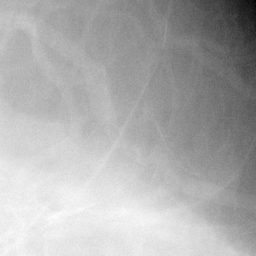

In [17]:
Gray.(zoom_pxiel_values(x[:,:,1,4]))

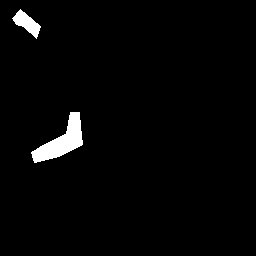

In [16]:
Gray.(y[:,:,1,4])

In [25]:
# saved_model_dir = "/home/molloi-lab/Desktop/Project BAC/BAC project/saved model/2"
saved_model_dir = "/home/molloi-lab/Desktop/Project BAC/BAC project"
# load ps and st
model_name = "saved_train_info_25.jld2"
model_path = joinpath(saved_model_dir, model_name)
@load model_path ps_save st_save
ps = ps_save |> dev
st = st_save |> dev
# create model
model = unet2D(1, 1);

In [26]:
x_gpu = x |> dev
ŷ_25 = model(x_gpu, ps, st)[1] |> cpu_device();

In [27]:
ŷ_25 == ŷ_50

false

In [147]:
size(ŷ)

(256, 256, 1, 6)

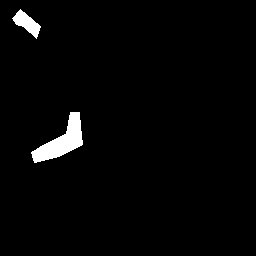

In [31]:
Gray.(y[:,:,1,4])

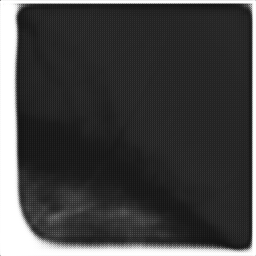

In [28]:
Gray.(ŷ_1[:,:,1,4])

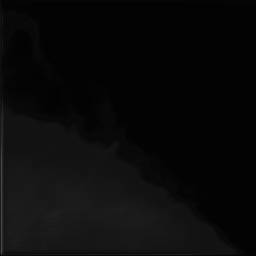

In [29]:
Gray.(ŷ_25[:,:,1,4])

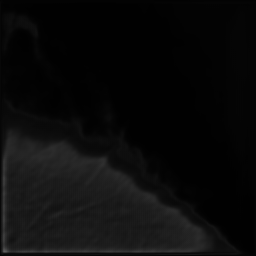

In [24]:
Gray.(ŷ_50[:,:,1,4])

In [30]:
Gray.(round.(ŷ[:,:,1,4])) # 6

UndefVarError: UndefVarError: `ŷ` not defined

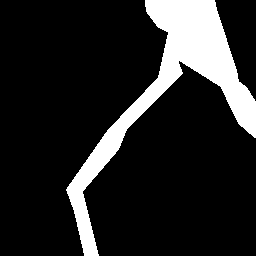

In [153]:
Gray.(y[:,:,1,4])

In [154]:
ϵ=1f-10
loss_dice = []
for i = 1:6
    l = 1f0 - (muladd(2f0, sum(ŷ[:,:,1,i] .* y[:,:,1,i]), ϵ) / (sum(ŷ[:,:,1,i] .^ 2) + sum(y[:,:,1,i] .^ 2) + ϵ))
    push!(loss_dice, l)
    println("$i: $l")
end

1: 0.5625272
2: 0.9868793
3: 0.86206573
4: 0.6198078
5: 0.61091185
6: 0.7954633


In [155]:
1f0 - (muladd(2f0, sum(ŷ[:,:,1,3] .* y[:,:,1,3]), ϵ) / (sum(ŷ[:,:,1,3] .^ 2) + sum(y[:,:,1,3] .^ 2) + ϵ))

0.86206573f0

In [156]:
mean(@. -xlogy(y, ŷ .+ ϵ) - xlogy(1f0 .- y, 1f0 .- ŷ .+ ϵ))

0.57708925f0

auto_continue_training (generic function with 1 method)

In [3]:
auto_continue_training()

10